In [77]:
import tensorflow as tf
from tensorflow.train import Feature, Features, Example, BytesList, Int64List
from contextlib import ExitStack

import matplotlib.pyplot as plt
import glob
import numpy as np
from datetime import datetime
from pathlib import Path

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = (
    tf.keras.datasets.fashion_mnist.load_data()
)
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [5]:
# creating training tf sets
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.shuffle(len(X_train), seed=42)
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [9]:
def create_example(image, label):

    image_data = tf.io.serialize_tensor(image)

    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }
        )
    )

In [23]:
def write_tfrecords(name, dataset, n_shards=10):
    paths = [
        "{}.tfrecord-{:05d}-of-{:05d}".format(name, index + 1, n_shards)
        for index in range(n_shards)
    ]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]

        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [ ]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

2025-03-26 21:37:26.504327: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
def preprocess(tfrecord):
    feature_dict = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
    }

    example = tf.io.parse_single_example(tfrecord, feature_dict)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    # image = tf.io.decode_jpeg(example["image"])
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]


def mnist_dataset(
    filepaths,
    n_read_threads=5,
    shuffle_buffer_size=None,
    n_parse_threads=5,
    batch_size=32,
    cache=True,
):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size=batch_size)
    return dataset.prefetch(1)

In [29]:
train_set = mnist_dataset(train_filepaths)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

2025-03-26 21:53:20.900625: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


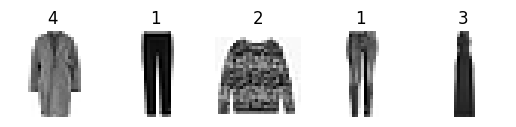

In [32]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [ ]:
tf.random.set_seed(42)
input_layer = tf.keras.Input(shape=(28, 28))
standardization = tf.keras.layers.Normalization()
sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(
    list(sample_image_batches.as_numpy_iterator()), axis=0
).astype(np.float32)
standardization.adapt(sample_images)

2025-03-26 22:16:47.702587: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
model = tf.keras.Sequential(
    [
        input_layer,
        standardization,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]
)
logs = Path() / "my_logs" / "run_" / datetime.now().strftime("%Y%m%d_%H%M%S")

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=logs, histogram_freq=1, profile_batch=10
)

model.fit(train_set, epochs=5, validation_data=valid_set, callbacks=[tensorboard_cb])

Epoch 1/5


2025-03-26 22:21:45.425404: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-03-26 22:21:45.425416: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2025-03-26 22:21:45.425484: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.


    144/Unknown 1s 1ms/step - accuracy: 0.6449 - loss: 1.0460

2025-03-26 22:21:46.205751: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-03-26 22:21:46.205770: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2025-03-26 22:21:46.208534: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:68] Profiler session collecting data.
2025-03-26 22:21:46.212072: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.
2025-03-26 22:21:46.214158: I external/local_xla/xla/tsl/profiler/rpc/client/save_profile.cc:147] Collecting XSpace to repository: my_logs/run_/20250326_222145/train/plugins/profile/2025_03_26_22_21_46/Chirags-Mac-mini.local.xplane.pb


   1700/Unknown 3s 1ms/step - accuracy: 0.8049 - loss: 0.5553

/Users/chiragbangera/Developer/Handsonml/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-03-26 22:21:48.688422: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8053 - loss: 0.5540 - val_accuracy: 0.8682 - val_loss: 0.3720
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8774 - loss: 0.3421 - val_accuracy: 0.8760 - val_loss: 0.3438
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8912 - loss: 0.2997 - val_accuracy: 0.8788 - val_loss: 0.3398
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8994 - loss: 0.2702 - val_accuracy: 0.8798 - val_loss: 0.3394
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9076 - loss: 0.2475 - val_accuracy: 0.8792 - val_loss: 0.3515
